У цьому ДЗ ми потренуємось розв'язувати задачу багатокласової класифікації за допомогою логістичної регресії з використанням стратегій One-vs-Rest та One-vs-One, оцінити якість моделей та порівняти стратегії.

### Опис задачі і даних

**Контекст**

В цьому ДЗ ми працюємо з даними про сегментацію клієнтів.

Сегментація клієнтів – це практика поділу бази клієнтів на групи індивідів, які схожі між собою за певними критеріями, що мають значення для маркетингу, такими як вік, стать, інтереси та звички у витратах.

Компанії, які використовують сегментацію клієнтів, виходять з того, що кожен клієнт є унікальним і що їхні маркетингові зусилля будуть більш ефективними, якщо вони орієнтуватимуться на конкретні, менші групи зі зверненнями, які ці споживачі вважатимуть доречними та які спонукатимуть їх до купівлі. Компанії також сподіваються отримати глибше розуміння уподобань та потреб своїх клієнтів з метою виявлення того, що кожен сегмент цінує найбільше, щоб точніше адаптувати маркетингові матеріали до цього сегменту.

**Зміст**.

Автомобільна компанія планує вийти на нові ринки зі своїми існуючими продуктами (P1, P2, P3, P4 і P5). Після інтенсивного маркетингового дослідження вони дійшли висновку, що поведінка нового ринку схожа на їхній існуючий ринок.

На своєму існуючому ринку команда з продажу класифікувала всіх клієнтів на 4 сегменти (A, B, C, D). Потім вони здійснювали сегментовані звернення та комунікацію з різними сегментами клієнтів. Ця стратегія працювала для них надзвичайно добре. Вони планують використати ту саму стратегію на нових ринках і визначили 2627 нових потенційних клієнтів.

Ви маєте допомогти менеджеру передбачити правильну групу для нових клієнтів.

В цьому ДЗ використовуємо дані `customer_segmentation_train.csv`[скачати дані](https://drive.google.com/file/d/1VU1y2EwaHkVfr5RZ1U4MPWjeflAusK3w/view?usp=sharing). Це `train.csv`з цього [змагання](https://www.kaggle.com/datasets/abisheksudarshan/customer-segmentation/data?select=train.csv)

**Завдання 1.** Завантажте та підготуйте датасет до аналізу. Виконайте обробку пропущених значень та необхідне кодування категоріальних ознак. Розбийте на тренувальну і тестувальну вибірку, де в тесті 20%. Памʼятаємо, що весь препроцесинг ліпше все ж тренувати на тренувальній вибірці і на тестувальній лише використовувати вже натреновані трансформери.
Але в даному випадку оскільки значень в категоріях небагато, можна зробити обробку і на оригінальних даних, а потім розбити - це простіше. Можна також реалізувати процесинг і тренування моделі з пайплайнами. Обирайте як вам зручніше.

In [135]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split



In [136]:
df = pd.read_csv('customer_segmentation_train.csv')
print(df.shape)
df.head()

(8068, 11)


,ID,Gender,Ever_Married,Age,Graduated,Profession,Work_Experience,Spending_Score,Family_Size,Var_1,Segmentation
0,462809,Male,No,22,No,Healthcare,1.0,Low,4.0,Cat_4,D
1,462643,Female,Yes,38,Yes,Engineer,NaN,Average,3.0,Cat_4,A
2,466315,Female,Yes,67,Yes,Engineer,1.0,Low,1.0,Cat_6,B
3,461735,Male,Yes,67,Yes,Lawyer,0.0,High,2.0,Cat_6,B
4,462669,Female,Yes,40,Yes,Entertainment,NaN,High,6.0,Cat_6,A


In [137]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8068 entries, 0 to 8067
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   ID               8068 non-null   int64  
 1   Gender           8068 non-null   object 
 2   Ever_Married     7928 non-null   object 
 3   Age              8068 non-null   int64  
 4   Graduated        7990 non-null   object 
 5   Profession       7944 non-null   object 
 6   Work_Experience  7239 non-null   float64
 7   Spending_Score   8068 non-null   object 
 8   Family_Size      7733 non-null   float64
 9   Var_1            7992 non-null   object 
 10  Segmentation     8068 non-null   object 
dtypes: float64(2), int64(2), object(7)
memory usage: 693.5+ KB


In [138]:
df.isnull().sum()

ID                   0
Gender               0
Ever_Married       140
Age                  0
Graduated           78
Profession         124
Work_Experience    829
Spending_Score       0
Family_Size        335
Var_1               76
Segmentation         0
dtype: int64

In [139]:
df.Ever_Married.value_counts()

Ever_Married
Yes    4643
No     3285
Name: count, dtype: int64

In [140]:
df.Family_Size.value_counts()

Family_Size
2.0    2390
3.0    1497
1.0    1453
4.0    1379
5.0     612
6.0     212
7.0      96
8.0      50
9.0      44
Name: count, dtype: int64

In [141]:
#df['Family_Size'] = df['Family_Size'].astype('Int16')
#df['Work_Experience'] = df['Work_Experience'].astype('Int16')
df[df['Ever_Married'].isnull()].head(3)

,ID,Gender,Ever_Married,Age,Graduated,Profession,Work_Experience,Spending_Score,Family_Size,Var_1,Segmentation
24,461021,Female,NaN,58,No,Executive,1.0,Average,3.0,Cat_3,B
108,466466,Female,NaN,19,No,Healthcare,6.0,Low,5.0,Cat_3,D
201,466065,Male,NaN,19,No,Healthcare,9.0,Low,3.0,Cat_3,D


In [142]:
df['Family_Size'] = df['Family_Size'].fillna(0)
df['Family_Size'].isnull().sum()

np.int64(0)

In [143]:
## Заповнимо порожні значення в Ever_Married, якщо ознака Family_Size не дорівнює 0
def fill_ever_marr(row): 
    if (pd.isnull(row['Ever_Married']) and row['Family_Size'] != 0):
        row['Ever_Married'] = 'Yes'
    if (pd.isnull(row['Ever_Married']) and row['Family_Size'] == 0):
        row['Ever_Married'] = 'No'
    return row['Ever_Married']
df['Ever_Married'] = df.apply(fill_ever_marr, axis=1)
df['Ever_Married'].value_counts()


Ever_Married
Yes    4771
No     3297
Name: count, dtype: int64

In [144]:
df.isnull().sum()

ID                   0
Gender               0
Ever_Married         0
Age                  0
Graduated           78
Profession         124
Work_Experience    829
Spending_Score       0
Family_Size          0
Var_1               76
Segmentation         0
dtype: int64

In [145]:
df['Graduated'].value_counts()

Graduated
Yes    4968
No     3022
Name: count, dtype: int64

In [146]:
# Заповнимо порожні значення найчастішим зустрічающимся значенням
graduated_mode = df['Graduated'].mode().values[0]
df['Graduated'] = df['Graduated'].fillna(graduated_mode)
df['Graduated'].value_counts()

Graduated
Yes    5046
No     3022
Name: count, dtype: int64

In [147]:
df.Work_Experience.value_counts()

Work_Experience
1.0     2354
0.0     2318
9.0      474
8.0      463
2.0      286
3.0      255
4.0      253
6.0      204
7.0      196
5.0      194
10.0      53
11.0      50
12.0      48
13.0      46
14.0      45
Name: count, dtype: int64

Text(0, 0.5, 'Age')

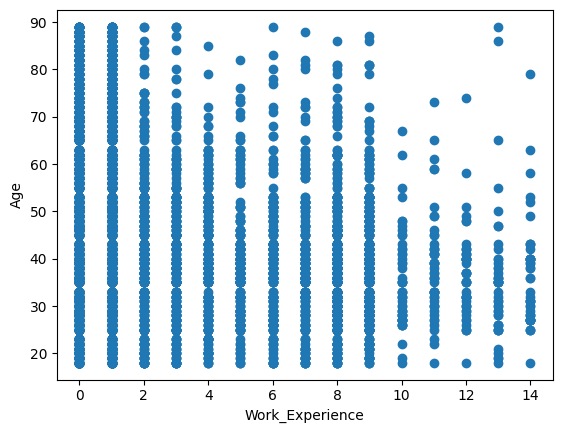

In [148]:
plt.scatter(df.Work_Experience, df.Age)
plt.xlabel('Work_Experience')
plt.ylabel('Age')

In [149]:
# Є тенденція збільшений досвід тільки 50-60 років віку.
# Але ці всі значення в відсотковому співвідношенні не такі великі, як 1 та 0. Тому просто заповню порожні значення досвіду значенням 1
work_exp = df['Work_Experience'].mode().values[0]
df['Work_Experience'] = df['Work_Experience'].fillna(work_exp)
df['Work_Experience'].value_counts()
df.isnull().sum()

ID                   0
Gender               0
Ever_Married         0
Age                  0
Graduated            0
Profession         124
Work_Experience      0
Spending_Score       0
Family_Size          0
Var_1               76
Segmentation         0
dtype: int64

In [150]:
df.Profession.value_counts()
# Аналогічно для ознаки Profession
profession = df['Profession'].mode().values[0]
df['Profession'] = df['Profession'].fillna(profession)
df['Profession'].value_counts()
df.isnull().sum()

ID                  0
Gender              0
Ever_Married        0
Age                 0
Graduated           0
Profession          0
Work_Experience     0
Spending_Score      0
Family_Size         0
Var_1              76
Segmentation        0
dtype: int64

In [151]:
df.Var_1.value_counts()
# Аналогічно для ознаки Profession
var1 = df['Var_1'].mode().values[0]
df['Var_1'] = df['Var_1'].fillna(var1)
df['Var_1'].value_counts()
df.isnull().sum()

ID                 0
Gender             0
Ever_Married       0
Age                0
Graduated          0
Profession         0
Work_Experience    0
Spending_Score     0
Family_Size        0
Var_1              0
Segmentation       0
dtype: int64

In [152]:
# Кодуємо ознаки Profession, Spending_Score, Var_1  за допомогою OneHotEncoder
ohenc1 = OneHotEncoder()
ohe_columns1 = ['Profession']
ohenc1.fit(df[ohe_columns1])
one_hot1 = ohenc1.transform(df[ohe_columns1]).toarray()
df[ohenc1.categories_[0]] = one_hot1


ohenc2 = OneHotEncoder()
ohe_columns2 = ['Spending_Score']
ohenc2.fit(df[ohe_columns2])
one_hot2 = ohenc2.transform(df[ohe_columns2]).toarray()
df[ohenc2.categories_[0]] = one_hot2

ohenc3 = OneHotEncoder()
ohe_columns3 = ['Var_1']
ohenc3.fit(df[ohe_columns3])
one_hot3 = ohenc3.transform(df[ohe_columns3]).toarray()
df[ohenc3.categories_[0]] = one_hot3


df.head(3)

,ID,Gender,Ever_Married,Age,Graduated,Profession,Work_Experience,Spending_Score,Family_Size,Var_1,...,Average,High,Low,Cat_1,Cat_2,Cat_3,Cat_4,Cat_5,Cat_6,Cat_7
0,462809,Male,No,22,No,Healthcare,1.0,Low,4.0,Cat_4,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,462643,Female,Yes,38,Yes,Engineer,1.0,Average,3.0,Cat_4,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,466315,Female,Yes,67,Yes,Engineer,1.0,Low,1.0,Cat_6,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [153]:
one_hot1

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], shape=(8068, 9))

In [154]:
# Перетворимо категоріальни ознаки с 2-ічними значеннями на бінарні
df['Ever_Married'] = np.where(df['Ever_Married']=='Yes', 1, 0)
df['Graduated'] = np.where(df['Graduated']=='Yes', 1, 0)
df['Gender'] = np.where(df['Gender']=='Female', 1, 0)
df.head(10)

,ID,Gender,Ever_Married,Age,Graduated,Profession,Work_Experience,Spending_Score,Family_Size,Var_1,...,Average,High,Low,Cat_1,Cat_2,Cat_3,Cat_4,Cat_5,Cat_6,Cat_7
0,462809,0,0,22,0,Healthcare,1.0,Low,4.0,Cat_4,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,462643,1,1,38,1,Engineer,1.0,Average,3.0,Cat_4,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,466315,1,1,67,1,Engineer,1.0,Low,1.0,Cat_6,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,461735,0,1,67,1,Lawyer,0.0,High,2.0,Cat_6,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,462669,1,1,40,1,Entertainment,1.0,High,6.0,Cat_6,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
5,461319,0,1,56,0,Artist,0.0,Average,2.0,Cat_6,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
6,460156,0,0,32,1,Healthcare,1.0,Low,3.0,Cat_6,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
7,464347,1,0,33,1,Healthcare,1.0,Low,3.0,Cat_6,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
8,465015,1,1,61,1,Engineer,0.0,Low,3.0,Cat_7,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
9,465176,1,1,55,1,Artist,1.0,Average,4.0,Cat_6,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [155]:
# Видалимо нечисельни колонки, також ID, розділимо на тренувальний і тестувальний набори
X, y = df.drop(columns=['Segmentation', 'ID']), df['Segmentation']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=df['Segmentation'])
X_train = X_train.drop(columns = X_train.select_dtypes(include=['object']))
X_test = X_test.drop(columns = X_test.select_dtypes(include=['object']))
X_train.head()


,Gender,Ever_Married,Age,Graduated,Work_Experience,Family_Size,Artist,Doctor,Engineer,Entertainment,...,Average,High,Low,Cat_1,Cat_2,Cat_3,Cat_4,Cat_5,Cat_6,Cat_7
917,1,0,32,1,9.0,1.0,1.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3398,0,1,72,1,1.0,2.0,0.0,0.0,0.0,1.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2045,1,0,33,1,1.0,4.0,0.0,0.0,0.0,1.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
8060,1,1,48,1,0.0,6.0,1.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4604,1,1,28,0,9.0,1.0,0.0,1.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


**Завдання 2. Важливо уважно прочитати все формулювання цього завдання до кінця!**

Застосуйте методи ресемплингу даних SMOTE та SMOTE-Tomek з бібліотеки imbalanced-learn до тренувальної вибірки. В результаті у Вас має вийти 2 тренувальних набори: з апсемплингом зі SMOTE, та з ресамплингом з SMOTE-Tomek.

Увага! В нашому наборі даних є як категоріальні дані, так і звичайні числові. Базовий SMOTE не буде правильно працювати з категоріальними даними, але є його модифікація, яка буде. Тому в цього завдання є 2 виконання

  1. Застосувати SMOTE базовий лише на НЕкатегоріальних ознаках.

  2. Переглянути інформацію про метод [SMOTENC](https://imbalanced-learn.org/dev/references/generated/imblearn.over_sampling.SMOTENC.html#imblearn.over_sampling.SMOTENC) і використати цей метод в цій задачі. За цей спосіб буде +3 бали за це завдання і він рекомендований для виконання.

  **Підказка**: аби скористатись SMOTENC треба створити змінну, яка містить індекси ознак, які є категоріальними (їх номер серед колонок) і передати при ініціації екземпляра класу `SMOTENC(..., categorical_features=cat_feature_indeces)`.
  
  Ви також можете розглянути варіант використання варіації SMOTE, який працює ЛИШЕ з категоріальними ознаками [SMOTEN](https://imbalanced-learn.org/dev/references/generated/imblearn.over_sampling.SMOTEN.html)

In [158]:
# Я вже залишила тільки числові дані, тому буду використовувати SMOTE
y_train.value_counts()

Segmentation
D    1814
A    1578
C    1576
B    1486
Name: count, dtype: int64

In [159]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)
y_train_smote.value_counts()

Segmentation
A    1814
B    1814
C    1814
D    1814
Name: count, dtype: int64

In [160]:
from imblearn.under_sampling import TomekLinks

tomek = TomekLinks()
X_train_tomek, y_train_tomek = tomek.fit_resample(X_train, y_train)
y_train_tomek.value_counts()

Segmentation
D    1565
B    1486
C    1352
A    1262
Name: count, dtype: int64

**Завдання 3**.
  1. Навчіть модель логістичної регресії з використанням стратегії One-vs-Rest з логістичною регресією на оригінальних даних, збалансованих з SMOTE, збалансованих з Smote-Tomek.  
  2. Виміряйте якість кожної з натренованих моделей використовуючи `sklearn.metrics.classification_report`.
  3. Напишіть, яку метрику ви обрали для порівняння моделей.
  4. Яка модель найкраща?
  5. Якщо немає суттєвої різниці між моделями - напишіть свою гіпотезу, чому?

In [162]:

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.multiclass import OneVsRestClassifier

# Логістична регресія зі стратегією one-vs-rest (OvR) на оригінальних даних
log_reg_original = LogisticRegression(solver='liblinear')
ovr_model_original = OneVsRestClassifier(log_reg_original)
ovr_model_original.fit(X_train, y_train)
ovr_predictions_original = ovr_model_original.predict(X_test)

# Обчислимо метрики precision та recall для кожного класу
print(classification_report(y_test, ovr_predictions_original))

              precision    recall  f1-score   support

           A       0.42      0.46      0.44       394
           B       0.40      0.16      0.22       372
           C       0.49      0.64      0.55       394
           D       0.64      0.75      0.69       454

    accuracy                           0.51      1614
   macro avg       0.49      0.50      0.48      1614
weighted avg       0.50      0.51      0.49      1614



In [163]:
# Логістична регресія зі стратегією one-vs-rest (OvR) на даних, збалансованих зі SMOTE
log_reg_smote = LogisticRegression(solver='liblinear')
ovr_model_smote = OneVsRestClassifier(log_reg_smote)
ovr_model_smote.fit(X_train_smote, y_train_smote)
ovr_predictions_smote = ovr_model_smote.predict(X_test)

# Обчислимо метрики precision та recall для кожного класу
print(classification_report(y_test, ovr_predictions_smote))

              precision    recall  f1-score   support

           A       0.41      0.47      0.44       394
           B       0.39      0.24      0.30       372
           C       0.51      0.60      0.55       394
           D       0.68      0.70      0.69       454

    accuracy                           0.51      1614
   macro avg       0.50      0.50      0.49      1614
weighted avg       0.50      0.51      0.50      1614



In [164]:
# Логістична регресія зі стратегією one-vs-rest (OvR) на даних, збалансованих зі Tomek-Links
log_reg_tomek = LogisticRegression(solver='liblinear')
ovr_model_tomek = OneVsRestClassifier(log_reg_tomek)
ovr_model_tomek.fit(X_train_tomek, y_train_tomek)
ovr_predictions_tomek = ovr_model_tomek.predict(X_test)

# Обчислимо метрики precision та recall для кожного класу
print(classification_report(y_test, ovr_predictions_tomek))

              precision    recall  f1-score   support

           A       0.43      0.38      0.40       394
           B       0.37      0.34      0.35       372
           C       0.53      0.54      0.54       394
           D       0.65      0.75      0.70       454

    accuracy                           0.51      1614
   macro avg       0.49      0.50      0.50      1614
weighted avg       0.50      0.51      0.51      1614



Висновок
Мені здається, що немає значної різниці між результатами, отриманними від трьох наборів. Принципово ві результати однакові. І причина цього - немає значного дісбалансу класів. 